In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import scipy.linalg
import scipy.integrate
import scipy.signal
import matplotlib.cm

## Goodwin's Oscillator

We will examine how the amplitude and period are affected by each parameter in the system. Each state is produced at a rate proportional to $\alpha_{1,2,3}$ and destroyed at a rate proportional to $\gamma_{1,2,3}$. Z down-regulates X with activation threshold $K$ and Hill coefficient $n$.
<div>
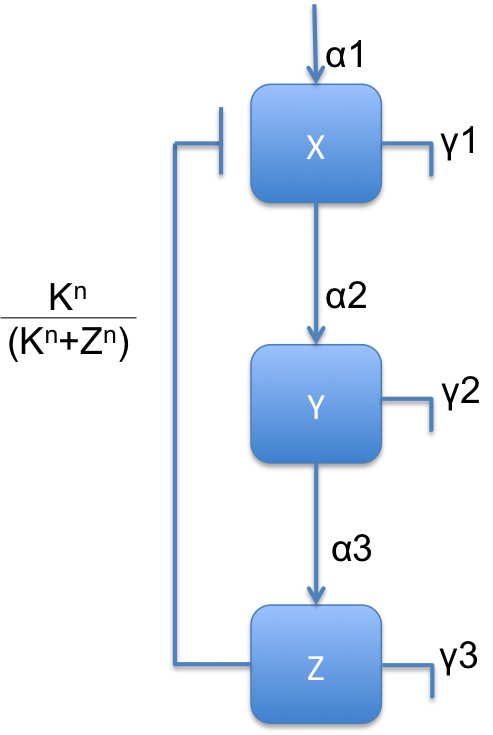
</div>

Copy code from Lecture 22: goodwin_oscillator, get_period, goodwin_period, goodwin_amplitude, and sensitivity.

In [3]:
def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt


def get_period(t,x):
    """ Approximate the period of a 1-D x, given the time-steps t.
        Returns a tuple with the period and the standard deviation of the period over time.
        if the value of the standard deviation is not smaller than 0.1, then
        it means the period estimate is dodgy and you shouldn't use it. Instead,
        plot your simulation and figure out why it isn't periodic - maybe it just
        hasn't reached the limit cycle yet."""
    idxs = scipy.signal.find_peaks(x)
    idxs = idxs[0]
    times = t[idxs]
    period = np.mean(np.diff(times));
    sdperiod = np.sqrt(np.var(np.diff(times)));
    return (period,sdperiod)

def simulate_goodwin( params, t0=0, tStop=240, dt=0.1 ):
    yinit = np.ones((3,));
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=yinit, method='RK45', 
                                    t_eval=np.arange(0,10*24,0.1), args=[params] )
    sol = scipy.integrate.solve_ivp(fun=goodwin_oscillator, t_span=(0,10*24), y0=sol.y[:,-1], method='RK45', 
                                    t_eval=np.arange(t0,tStop,dt), args=[params], rtol=1e-8 )

    return sol

def goodwin_period( params ):
    sol = simulate_goodwin( params )
    (per,sdper) = get_period( sol.t, sol.y[0,:] )
    return per

def goodwin_amplitude( params, which_state=-1 ):
    """ Return the amplitude of the given state or of the sum of all three states
        If which_state  == -1, then return the sum of all 3.
        Otherwise, which_state should be 0 (for M), 1 (for P), or 2 (for I)
    """
    sol = simulate_goodwin( params )
    if which_state == -1:
        return np.sum(sol.y.max(axis=1)-sol.y.min(axis=1))
    else:
        return sol.y[which_state,:].max() - sol.y[which_state,:].min()

    
def sensitivity( fcn, ref_params, frac_change ):
    """
    fcn should be a handle to a function that takes a parameter set as input
        and returns a scalar as output.
    ref_params should be a 1D ndarray with the parameter set
    frac_change is the perturbation size, as a scale (i.e. the fraction by which you want to adjust the parameter by)
    """
    ref = fcn( ref_params );
    Srel = np.zeros((ref_params.size,));
    for i in range(ref_params.size):
        params = ref_params.copy();
        params[i] = (1+frac_change)*ref_params[i];
        output = fcn( params );
        Srel[i] = (output-ref)/frac_change;
    return Srel    

### Confirm the code works

Plot the simulation, period, and amplitude for a particular set of parameters.

period 22.240000000000002
amplitude of X 0.078766758608702
amplitude of Y 0.22063799095092582
amplitude of Z 0.5787024185615389
amplitude of X+Y+Z 0.8781071681211667


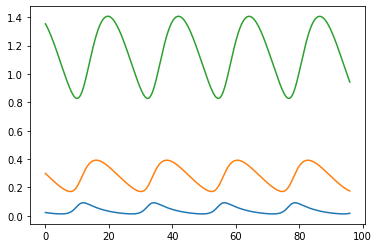

In [5]:
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25

pub_params = [alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3]
param_names = ['alpha_1','K','n','gamma_1','alpha_2','gamma_2','alpha _3','gamma_3']

per = goodwin_period( pub_params )
print("period", per)
amp1 = goodwin_amplitude( pub_params, which_state = 0 )
print( "amplitude of X", amp1)
amp2 = goodwin_amplitude( pub_params, which_state = 1 )
print( "amplitude of Y", amp2)
amp3 = goodwin_amplitude( pub_params, which_state = 2 )
print( "amplitude of Z", amp3)
ampTot = goodwin_amplitude( pub_params, which_state = -1 )
print( "amplitude of X+Y+Z", ampTot)

sol = simulate_goodwin( pub_params, tStop=4*24)
plt.plot( sol.t, sol.y.T );

### Load in the parameter sets

OK, "load in" is not the correct phrase to use here. But in your project, you will be reading it in from files generated by your GA. I did that (commented out code), but then hard-coded the results here, so I can send this to you easily.

The good parameter sets are placed into an ND-array called good_params that is num_runs x num_params in size.

In [20]:
# Stephanie generated 10 total good parameters sets from GA runs with tournaments
# of size 2 and 5. She read in those values and printed them. She used her print statement to write
# code to store all of these parameter sets in one array. This way, you get her data without her
# needing to download additional files.
# good_params = np.zeros((5,len(pub_params)))
# for run_num in range(1,6):
# #     fn = "Goodwin_tournament2_run%d.npz" % run_num
# #     fn = "Goodwin_tournament5_run%d.npz" % run_num
#     f = np.load( fn )
#     good_params[run_num-1,:] = f['params']
# print(good_params)

good_params = np.array([[ 0.89876294,  0.24121646, 12.61302454,  0.14941301,  0.30750053,  0.18439661,
   0.56189415,  0.20425961],
 [ 1.23693436,  0.58349462, 15.,          0.13586239,  1.69970728,  0.19937136,
   0.2735245,   0.23612367],
 [ 0.94945619,  0.92784674, 11.39020364,  0.13996266,  0.40513268,  0.26454114,
   1.51845567,  0.1039259 ],
 [ 1.17162395,  0.81555878, 14.56140512,  0.20103341,  1.68024694,  0.20074433,
   1.67255027,  0.17010709],
 [ 1.77343247,  0.94861616, 12.87504692,  0.14493826,  2.,          0.16729553,
   1.08688529,  0.23543582],
 [ 1.28044873,  0.93953788, 12.12183418,  0.10549222,  0.40131576,  0.18400752,
   1.28359836,  0.2291318 ],
 [ 0.82054474,  0.47903044, 14.2552747,   0.18387238,  0.86966745,  0.18991038,
   1.08949378,  0.19308202],
 [ 0.70749929,  1.55332042, 13.89779308,  0.24428243, 0.64742206,  0.18850616,
   0.56042951,  0.09254498],
 [ 1.31136761,  1.37678993, 12.64637329,  0.20776551,  1.82882169,  0.16439259,
   1.09992989,  0.16995682],
 [ 1.53463766,  1.01858614, 13.51049662,  0.16209234,  1.60438497,  0.24525404,
   0.48755653,  0.14482767]])

### Confirm that all 10 oscillators are "good"

For each set of parameters (each row in good_params), print the period and the amplitude of each state. The period should be close to 23.6 and no state should have an amplitude smaller than 0.1.

In [23]:
for i in range(good_params.shape[0]):
    print( "period = %0.2f, amp X = %0.2f, amp Y = %0.2f, amp Z = %0.2f" % 
              (goodwin_period( good_params[i,:]),
               goodwin_amplitude( good_params[i,:], which_state=0 ),
               goodwin_amplitude( good_params[i,:], which_state=1 ),
               goodwin_amplitude( good_params[i,:], which_state=2 )) )

period = 23.88, amp X = 0.22, amp Y = 0.18, amp Z = 0.30
period = 23.96, amp X = 0.27, amp Y = 1.11, amp Z = 0.84
period = 24.01, amp X = 0.11, amp Y = 0.11, amp Z = 0.61
period = 24.12, amp X = 0.08, amp Y = 0.29, amp Z = 1.53
period = 23.96, amp X = 0.08, amp Y = 0.45, amp Z = 1.36
period = 24.02, amp X = 0.20, amp Y = 0.23, amp Z = 0.82
period = 24.01, amp X = 0.12, amp Y = 0.25, amp Z = 0.82
period = 24.04, amp X = 0.32, amp Y = 0.56, amp Z = 1.11
period = 24.03, amp X = 0.12, amp Y = 0.58, amp Z = 1.99
period = 24.02, amp X = 0.23, amp Y = 0.84, amp Z = 1.34


### Compute the sensitivities.

For each of the good parameter sets, compute the sensitivity of the period, the sensitivity of the amplitude of X, the sensitivity of the amplitude of Y, the sensitivity of the amplitude of Z, and the sensitivity of the sum of all three amplitudes. Each result should be in an ND-array of size num_runs x num_params.

Save the results in a file named goodwin_sensitivity.npz. If that file already exists, just read it in.

In [43]:
num_params = good_params.shape[1]
num_runs = good_params.shape[0]

fn = 'goodwin_sensitivity.npz'

if not os.path.isfile( fn ):
    pRel = np.zeros((num_runs,num_params))
    aXRel = np.zeros((num_runs,num_params))
    aYRel = np.zeros((num_runs,num_params))
    aZRel = np.zeros((num_runs,num_params))
    aTRel = np.zeros((num_runs,num_params))

    for run_num in range(num_runs):
        pRel[run_num,:] = sensitivity( goodwin_period, np.array(good_params[run_num,:]), 0.05 )
        aXRel[run_num,:] = sensitivity( lambda p: goodwin_amplitude( p, which_state = 0), good_params[run_num,:], 0.05 )
        aYRel[run_num,:] = sensitivity( lambda p: goodwin_amplitude( p, which_state = 1), good_params[run_num,:], 0.05 )
        aZRel[run_num,:] = sensitivity( lambda p: goodwin_amplitude( p, which_state = 2), good_params[run_num,:], 0.05 )
        aTRel[run_num,:] = sensitivity( lambda p: goodwin_amplitude( p, which_state = -1), good_params[run_num,:], 0.05 )
    np.savez( fn, pRel=pRel, aXRel=aXRel, aYRel=aYRel, aZRel=aZRel, aTRel=aTRel )

else:
    f = np.load( fn )
    pRel = f['pRel']
    aXRel = f['aXRel']
    aYRel = f['aYRel']
    aZRel = f['aZRel']
    aTRel = f['aTRel']


### Plot the sensitivities

For each type of sensitivity, make a boxplot. The x-axis should be labeled with the parameter names.

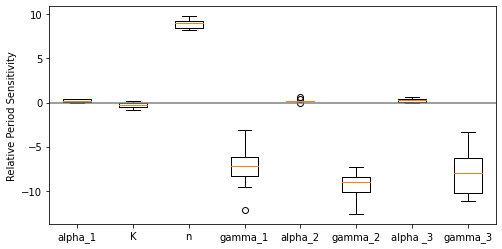

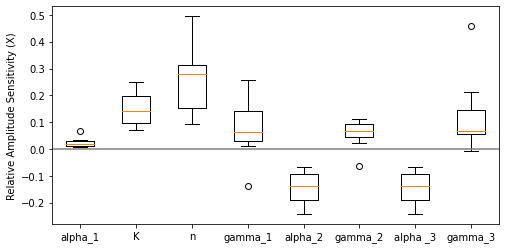

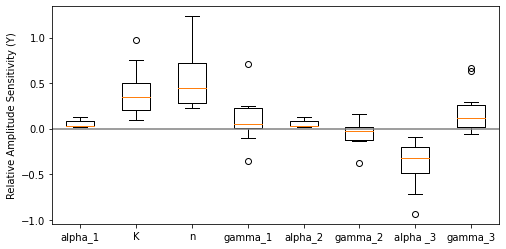

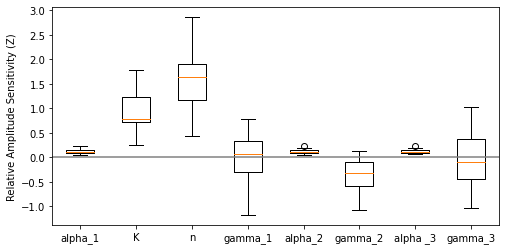

In [45]:
plt.figure( figsize=(8,4) )
plt.boxplot( pRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Period Sensitivity')
plt.figure( figsize=(8,4) )
plt.boxplot( aXRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (X)')
plt.figure( figsize=(8,4) )
plt.boxplot( aYRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (Y)')
plt.figure( figsize=(8,4) )
plt.boxplot( aZRel );
plt.axhline(color='gray')
plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
plt.ylabel( 'Relative Amplitude Sensitivity (Z)');
# plt.figure( figsize=(8,4) )
# plt.boxplot( aTRel );
# plt.axhline(color='gray')
# plt.xticks( ticks=np.arange(1,len(param_names)+1), labels=param_names);
# plt.ylabel( 'Relative Amplitude Sensitivity (sum of states)');